# Composition Axon Projection

In this example, we show how neurons can be connected by using detailed axonal reconstructions disjunct from their soma. In essence, axonal reconstructions are placed in the volume similar to how ordinary neurons are placed, and then connected using touch detection. This is useful when connecting different regions together, especially for somatotopically organized projection patterns. 

To define a new projection, the following should be defined in a .json-file:
 - a mapping between points in the source and target regions (intermediate values are interpolated),
 - a list of morphologies to use, and optionally,
 - the rotation of the termination zone.

### Minimal Example of a Configuration File
For example, the file may look like this:


```
{
    "ExampleProjection" : {
        "projection" : {
            "source" : [[4850, -150, -150],
                        [4850, -150, 150],
                        [4850, 150, -150],
                        [4850, 150, 150],
                        [5150, -150, -150],
                        [5150, -150, 150],
                        [5150, 150, -150],
                        [5150, 150, 150]],
            
            "destination" : [[-5150, -150, -150],
                             [-5150, -150, 150],
                             [-5150, 150, -150],
                             [-5150, 150, 150],
                             [-4850, -150, -150],
                             [-4850, -150, 150],
                             [-4850, 150, -150],
                             [-4850, 150, 150]]
    },

     "morphologies" : ["$SNUDDA_DATA/InputAxons/GPe2Striatum/prototypical-axon.swc"],
     
     "rotation" : {
            "rotation": [[1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1]]}
    }

}
```
Here, a neuron at ```[4850, -150, -150]``` will project to a neuron at ```[-5150, -150, -150]```.

Once the location of the termination zone is calculated, an axonal reconstruction is chosen randomly from 'morphologies'. The morphology is then rotated based on the rotation supplied. 


### Configuration File Using Paths
If the number of points used in the mapping is large, alternatively, a path can be specified:

```
{
    "ExampleProjection" : {
        "projection" : {
            "file" : "$SNUDDA_DATA/InputAxons/GPe2Striatum/projection_map.json",
    },

     "morphologies" : ["$SNUDDA_DATA/InputAxons/GPe2Striatum/prototypical-axon.swc"],
     
     "rotation" : {
            "file": "$SNUDDA_DATA/InputAxons/GPe2Striatum/rotation_map.json"
    }

}
```

This functions similarily to the previous example. The projection map should look like the following:

```
{
    "source" : [...],
    "destination" : [...]
}
```

The rotation map: 
```
{
    "position": [...],
    "rotation": [...]
}
```

Optionally, a 'mapping' parameter can be supplied to rotation. If set to 'source', the rotation is decided based on the position of the source rather than the termination zone. 



## Define volumes
Here we use ```create_cube_mesh``` to create two cubical volumes with sides 300 micrometer that are 10 mm apart.

In [1]:
import os
from snudda.place import create_cube_mesh

network_path = os.path.join("networks", "composite_axon_example")
mesh_file_a = os.path.join(network_path, "mesh", "volume_A.obj")
mesh_file_b = os.path.join(network_path, "mesh", "volume_B.obj")

create_cube_mesh(mesh_file_a, [5e-3,0,0], 300e-6, "Volume A - connect structures example")
create_cube_mesh(mesh_file_b, [-5e-3,0,0], 300e-6, "Volume B - connect structures example")

rc = None

duration = 1.0

## Building the network
Below, we build a small network consisting of two separate volumes (using ```define_structure```) with neurons added to them (```add_neurons```). The .json-file containing the projection configuration is supplied as an argument, ```projection_file``` to ```add_neurons```.

In [2]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path, random_seed=123)

si.define_structure(struct_name="VolumeA", struct_mesh=mesh_file_a, d_min=15e-6, mesh_bin_width=50e-6)
si.define_structure(struct_name="VolumeB", struct_mesh=mesh_file_b, d_min=15e-6, mesh_bin_width=50e-6)

proj_file = os.path.join("$SNUDDA_DATA", "InputAxons", "GPe2Striatum", "example-projection-config.json")

si.add_neurons(name="dSPN", num_neurons=20, volume_id="VolumeA",
               neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"),
               axon_config=proj_file)
si.add_neurons(name="iSPN", num_neurons=20, volume_id="VolumeB",
               neuron_dir=os.path.join("$DATA","neurons","striatum","ispn"))

# Normally we would use add_neuron_target to connect the neurons in the same volume together, 
# but this time we want to use neuron_projection instead.

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"
pfdSPNiSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-DI-tmgaba-fit.json")

si.add_neuron_target(neuron_name="dSPN",
                     target_name="iSPN",
                     connection_type="GABA",
                     # projection_file=proj_file, # -- moved to add_neuron
                     projection_name="ExampleProjection",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=None, soft_max=None, mu2=None, a3=None,
                     conductance=[0.24e-9, 0.1e-9],
                     parameter_file=pfdSPNiSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": 0.7})

si.write_json()

Adding neurons: dSPN from dir /Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/data/neurons/striatum/ispn
Writing networks/composite_axon_example/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5


In [4]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc)
sd.detect()

Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 1166/11160 (36 neurons)
Processing hyper voxel : 886/11160 (32 neurons)
Processing hyper voxel : 887/11160 (31 neurons)
Processing hyper voxel : 1157/11160 (31 neurons)
Processing hyper voxel : 877/11160 (30 neurons)
Processing hyper voxel : 878/11160 (29 neurons)
Processing hyper voxel : 1165/11160 (29 neurons)
Processing hyper voxel : 1156/11160 (24 neurons)
Processing hyper voxel : 885/11160 (22 neurons)
Processing hyper voxel : 879/11160 (21 neurons)
Processing hyper voxel : 1964/11160 (20 neurons)
Processing hyper voxel : 1335/11160 (20 neurons)
Processing hyper voxel : 870/11160 (20 neurons)
Processing hyper voxel : 2001/11160 (20 neurons)
Processing hyper voxel : 757/11160 

In [5]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc)
sp.prune()

Read 61 out of total 61 synapses


In [6]:
from snudda.input import SnuddaInput

si = SnuddaInput(network_path=network_path, rc=rc, input_config_file="test-input.json")
si.generate()

Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5
Loading 40 neurons with 22 synapses and 0 gap junctions
Writing spikes to networks/composite_axon_example/input-spikes.hdf5


Loading 40 neurons with 22 synapses and 0 gap junctions
Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5


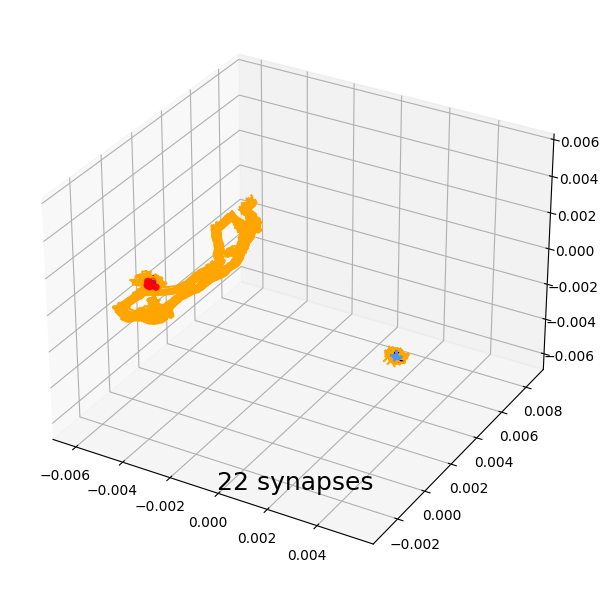

(<module 'matplotlib.pyplot' from '/Users/wilhelm/opt/anaconda3/envs/snudda/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <Axes3DSubplot: >)

In [7]:
from snudda.plotting import PlotNetwork
pn = PlotNetwork(network=network_path)
pn.plot()

In [8]:
from snudda.simulate import SnuddaSimulate
from snudda.core import Snudda

sim = SnuddaSimulate(network_path=network_path)
Snudda.compile_mechanisms()
sim.setup()
sim.add_external_input()
sim.add_volt_recording_soma()
sim.run(t=duration*1e3)
sim.write_output()

Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5
Loading 40 neurons with 22 synapses and 0 gap junctions
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64, aarch64, arm64 directories (or nrnmech.dll) then you will force a recompilation of the modules.
Warning! No modulation key specified, ignoring /Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/data/neurons/striatum/ispn/str-ispn-e150917_c11_D2-mWT-MSN1-v20190603/modulation.json
Warning! No modulation key specified, ignoring /Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/data/neurons/striatum/ispn/str-ispn-e150917_c11_D2-mWT-MSN1-v20190603/modulation.json
Warning! No modulation key specified, ignoring /Users/wilhelm/Dev/Projects/snudda-dev/Snudda/snudda/data/neurons/striatum/ispn/str-i

Loading 40 neurons with 22 synapses and 0 gap junctions
Loading networks/composite_axon_example/simulation/output.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
6: (iSPN_3, default, )
10: (iSPN_3, default, )
14: (iSPN_3, default, )
17: (iSPN_3, default, )
18: (iSPN_3, default, )
22: (dSPN_2, default, )
23: (dSPN_2, default, )
24: (dSPN_2, default, )
29: (dSPN_2, default, )
36: (dSPN_2, default, )
Saving figure to networks/composite_axon_example/figures/spike-raster.png


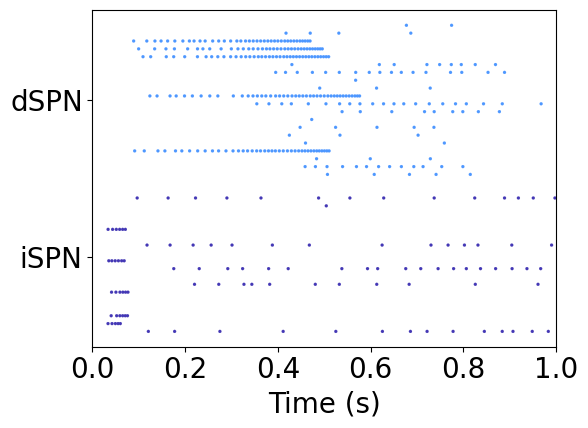

In [9]:
from snudda.plotting import SnuddaPlotSpikeRaster2
fig_file_raster = f"spike-raster.png"

time_range_zoom = (0,duration)
spr = SnuddaPlotSpikeRaster2(network_path=network_path)


spr.plot_spike_raster(fig_file=fig_file_raster, time_range=time_range_zoom)